# **Predictors of mental health illness** <br>
Kairos<br>
Created: 1/23/2018<br>
Last update: 6/23/2018<br>

This kernel is modified from the “starter kernel” by Megan Risdal<br>

### **Question:**
**Can you predict whether a patient should be treated of his/her mental illness or not according to the values obtained in the dataset?**

This is my first kernel after taking several courses of ML. I'm trying to understand better every concept by practicing and Kaggle is a good place to do it. Thanks Kaggle team.

The proccess is the following:
1. [Library and data loading](#Library_and_data_loading)
2. [Data cleaning](#Data_cleaning)
3. [Encoding data](#Encoding_data)
4. [Covariance Matrix. Variability comparison between categories of variables](#Covariance_Matrix)
5. [Some charts to see data relationship](#Some_charts_to_see_data_relationship)
6. [Scaling and fitting](#Scaling_and_fitting)
7. [Tuning](#Tuning)
8. [Evaluating models](#Evaluating_models)    
    1. [Logistic Eegression](#Logistic_regressio)
    2. [KNeighbors Classifier](#KNeighborsClassifier)
    3. [Decision Tree Classifier](#Decision_Tree_classifier)
    4. [Random Forests](#Random_Forests)
    5. [Bagging](#Bagging)
    6. [Boosting](#Boosting)
    7. [Stacking](#Stacking)
9. [Predicting with Neural Network](#Predicting_with_Neural_Network)
10. [Success method plot](#Success_method_plot)
11. [Creating predictions on test set](#Creating_predictions_on_test_set)
12. [Submission](#Submission)
13. [Conclusions](#Conclusions)


<a id='Library_and_data_loading'></a>
## **1. Library and data loading** ##

In [282]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import randint

# prep
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score

#Neural Network
from sklearn.neural_network import MLPClassifier


#Bagging
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#Naive bayes
from sklearn.naive_bayes import GaussianNB 

#Stacking


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


# Any results you write to the current directory are saved as output.

#reading in CSV's from a file path
train_df = pd.read_csv('survey.csv')


#Pandas: whats the data row count?
print(train_df.shape)
    
#Pandas: whats the distribution of the data?
print(train_df.describe())
    
#Pandas: What types of data do i have?
print(train_df.info())


(1259, 27)
                Age
count  1.259000e+03
mean   7.942815e+07
std    2.818299e+09
min   -1.726000e+03
25%    2.700000e+01
50%    3.100000e+01
75%    3.600000e+01
max    1.000000e+11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-n

<a id='Data_cleaning'></a>
## **2. Data cleaning** ##

In [ ]:
#missing data
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)


In [285]:
#dealing with missing data
#Let’s get rid of the variables "Timestamp",“comments”, “state” just to make our lives easier.
train_df = train_df.drop(['comments'], axis= 1)
train_df = train_df.drop(['state'], axis= 1)
train_df = train_df.drop(['Timestamp'], axis= 1)

train_df.isnull().sum().max() #just checking that there's no missing data missing...
train_df.head(5)

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


**Cleaning NaN**

In [ ]:
# Assign default values for each data type
defaultInt = 0
defaultString = 'NaN'
defaultFloat = 0.0

# Create lists by data tpe
intFeatures = ['Age']
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']
floatFeatures = []

# Clean the NaN's
for feature in train_df:
    if feature in intFeatures:
        train_df[feature] = train_df[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        train_df[feature] = train_df[feature].fillna(defaultString)
    elif feature in floatFeatures:
        train_df[feature] = train_df[feature].fillna(defaultFloat)
    else:
        print('Error: Feature %s not recognized.' % feature)
train_df.head(5)   

In [288]:
#clean 'Gender'
#Slower case all columm's elements
gender = train_df['Gender'].str.lower()
#print(gender)

#Select unique elements
gender = train_df['Gender'].unique()

#Made gender groups
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in train_df.iterrows():

    if str.lower(col.Gender) in male_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

#Get rid of bullshit
stk_list = ['A little about you', 'p']
train_df = train_df[~train_df['Gender'].isin(stk_list)]

print(train_df['Gender'].unique())

['female' 'male' 'trans']


In [290]:
#complete missing age with mean
train_df['Age'].fillna(train_df['Age'].median(), inplace = True)

# Fill with media() values < 18 and > 120
s = pd.Series(train_df['Age'])
s[s<18] = train_df['Age'].median()
train_df['Age'] = s
s = pd.Series(train_df['Age'])
s[s>120] = train_df['Age'].median()
train_df['Age'] = s

#Ranges of Age
train_df['age_range'] = pd.cut(train_df['Age'], [0,20,30,65,100], labels=["0-20", "21-30", "31-65", "66-100"], include_lowest=True)



In [292]:
#There are only 0.014% of self employed so let's change NaN to NOT self_employed
#Replace "NaN" string from defaultString
train_df['self_employed'] = train_df['self_employed'].replace([defaultString], 'No')
print(train_df['self_employed'].unique())

['No' 'Yes']


In [ ]:
#There are only 0.20% of self work_interfere so let's change NaN to "Don't know
#Replace "NaN" string from defaultString

train_df['work_interfere'] = train_df['work_interfere'].replace([defaultString], 'Don\'t know' )
print(train_df['work_interfere'].unique())

<a id='Encoding_data'></a>
## **3. Encoding data**

In [295]:
#Encoding data
labelDict = {}
for feature in train_df:
    le = preprocessing.LabelEncoder()
    le.fit(train_df[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    train_df[feature] = le.transform(train_df[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)

#Get rid of 'Country'
train_df = train_df.drop(['Country'], axis= 1)
train_df.head()



label_Age [1.7569999696917504e-08]
label_Gender ['female', 'male', 'trans']
label_Country ['Australia', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Mexico', 'Moldova', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'United Kingdom', 'United States', 'Uruguay', 'Zimbabwe']
label_self_employed ['No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ["Don't know", 'Never', 'Often', 'Rarely', 'Sometimes']
label_no_employees ['1-5', '100-500', '26-100', '500-1000', '6-25', 'More than 1000']
label_remote_work ['No', 'Yes']
label_tech_company ['No', 'Yes']
label_benefits ["

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,0
1,0,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,0
2,0,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,0
3,0,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,0
4,0,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,0


### Testing there aren't any missing data

In [ ]:
#missing data
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

Features Scaling
We're going to scale age, because is extremely different from the othere ones.

<a id='Covariance_Matrix'></a>
## **4. Covariance Matrix. Variability comparison between categories of variables** 

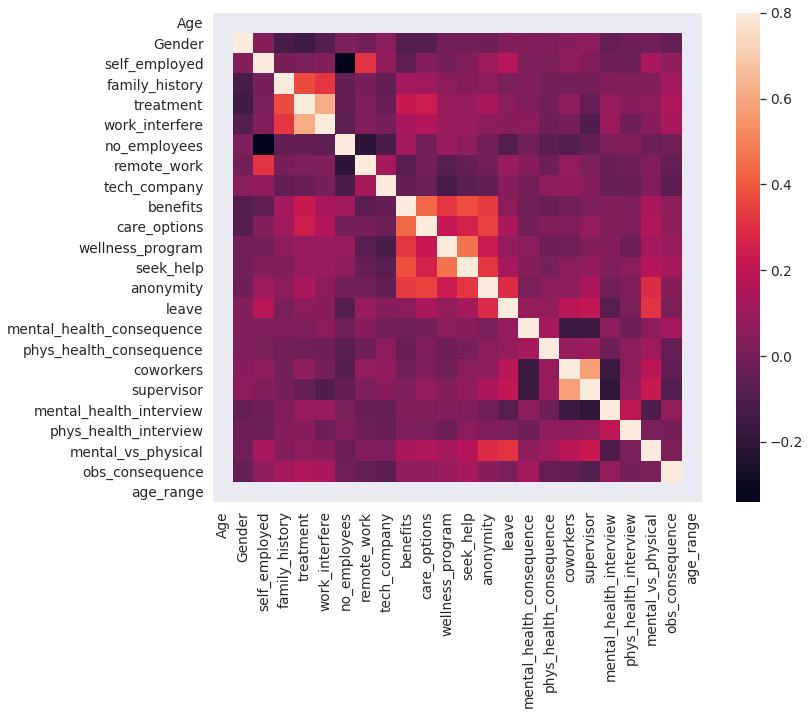

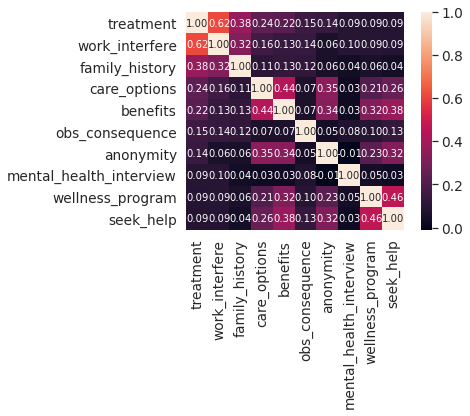

In [298]:
#correlation matrix
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

#treatment correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'treatment')['treatment'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()



<a id='Some_charts_to_see_data_relationship'></a>
## **5. Some charts to see data relationship** 

Distribiution and density by Age

Text(0.5, 0, 'Age')

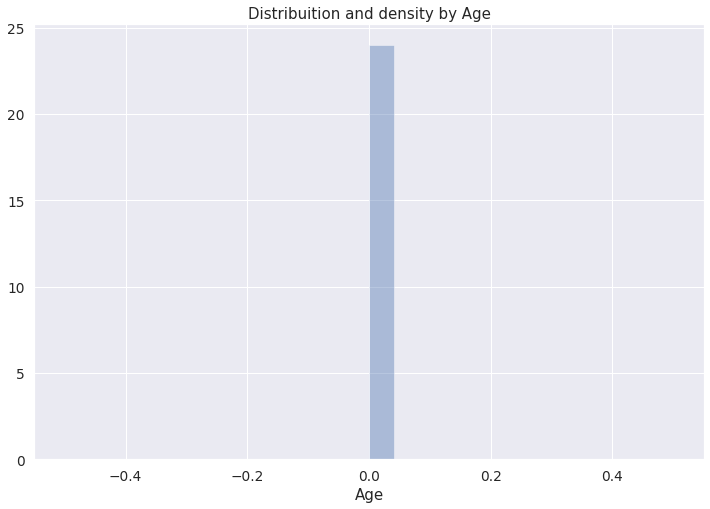

In [300]:
# Distribiution and density by Age
plt.figure(figsize=(12,8))
sns.distplot(train_df["Age"], bins=24)
plt.title("Distribuition and density by Age")
plt.xlabel("Age")



Separate by treatment

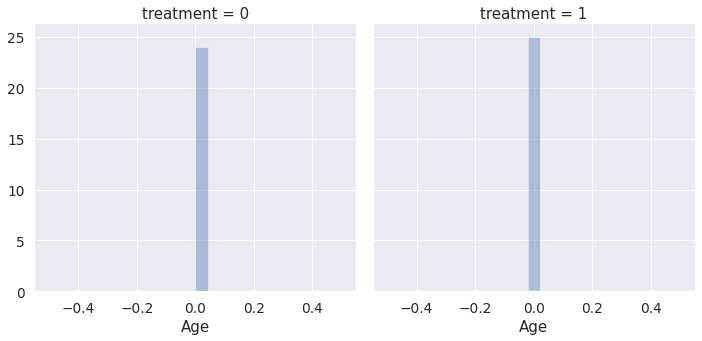

In [301]:
# Separate by treatment or not

g = sns.FacetGrid(train_df, col='treatment', size=5)
g = g.map(sns.distplot, "Age")

How many people has been treated?

Text(0.5, 1.0, 'Total Distribuition by treated or not')

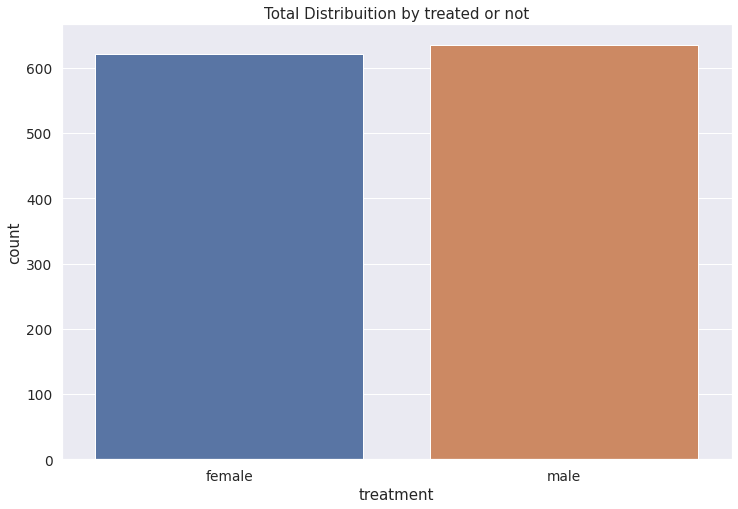

In [302]:
# Let see how many people has been treated
plt.figure(figsize=(12,8))
labels = labelDict['label_Gender']
g = sns.countplot(x="treatment", data=train_df)
g.set_xticklabels(labels)

plt.title('Total Distribuition by treated or not')

Draw a nested barplot to show probabilities for class and sex

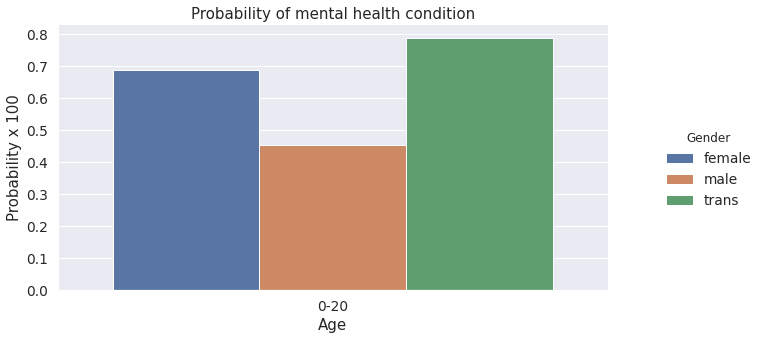

In [303]:
o = labelDict['label_age_range']

g = sns.factorplot(x="age_range", y="treatment", hue="Gender", data=train_df, kind="bar",  ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)

plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Age')
# replace legend labels

new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

Barplot to show probabilities for family history

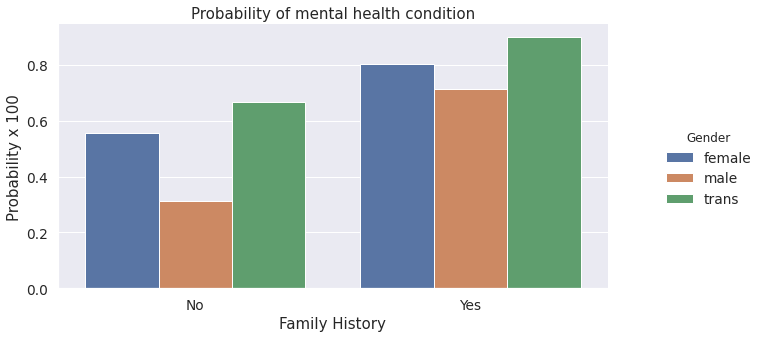

In [304]:
o = labelDict['label_family_history']
g = sns.factorplot(x="family_history", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Family History')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

Barplot to show probabilities for care options

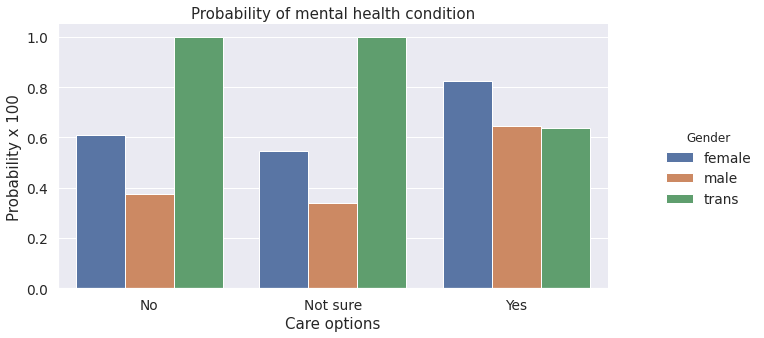

In [305]:
o = labelDict['label_care_options']
g = sns.factorplot(x="care_options", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Care options')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

Barplot to show probabilities for benefits

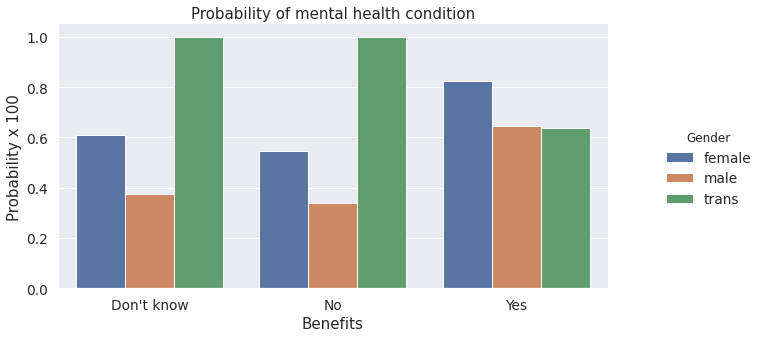

In [306]:
o = labelDict['label_benefits']
g = sns.factorplot(x="care_options", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Benefits')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

Barplot to show probabilities for work interfere

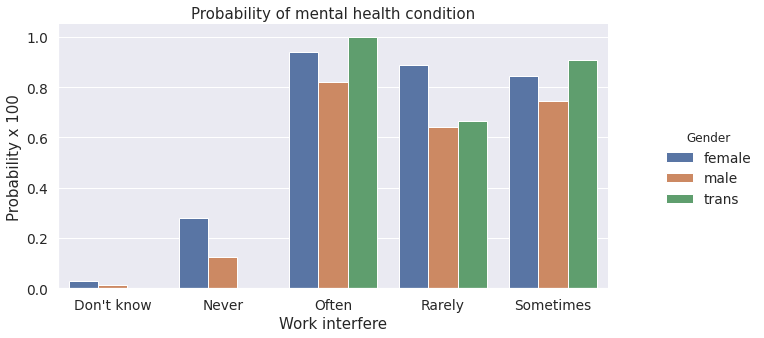

In [307]:
o = labelDict['label_work_interfere']
g = sns.factorplot(x="work_interfere", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Work interfere')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

<a id='Scaling_and_fitting'></a>
## **6. Scaling and fitting** ##



Features Scaling
We're going to scale age, because is extremely different from the othere ones.

In [308]:
# Scaling Age
scaler = MinMaxScaler()
train_df['Age'] = scaler.fit_transform(train_df[['Age']])
train_df.head()


,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.0,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,0
1,0.0,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,0
2,0.0,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,0
3,0.0,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,0
4,0.0,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,0


Spliltting the dataset

In [309]:
# define X and y
feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = train_df[feature_cols]
y = train_df.treatment

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Create dictionaries for final graph
# Use: methodDict['Stacking'] = accuracy_score
methodDict = {}
rmseDict = ()



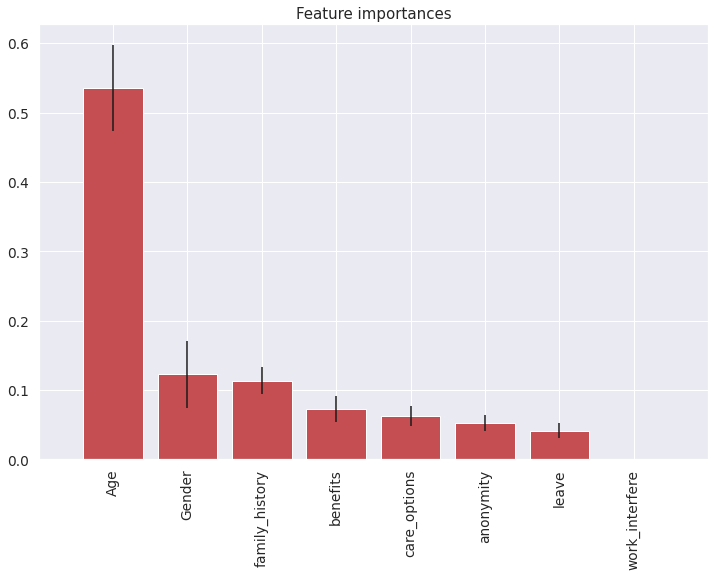

In [310]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

labels = []
for f in range(X.shape[1]):
    labels.append(feature_cols[f])      
    
# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

<a id='Boosting'></a>
### Boosting

<a id='Creating_predictions_on_test_set'></a>
## **11. Creating predictions on test set**

In [311]:
# Generate predictions with the best method
clf = AdaBoostClassifier()
clf.fit(X, y)


AdaBoostClassifier()

In [312]:
import pickle
pickle.dump(clf, open('model.pkl','wb'))